# Data visualization with t-SNE

Welcome to your 3-rd assignment in Unsupervised Machine Learning in Finance. This exercise will provide hands-on experience with non-linear models such as KernelPCA and t-SNE.

**Instructions:**
- You will be using Python 3.
- Avoid using for-loops and while-loops, unless you are explicitly told to do so.
- Do not modify the (# GRADED FUNCTION [function name]) comment in some cells. Your work would not be graded if you change this. Each cell containing that comment should only contain one function.
- After coding your function, run the cell right below it to check if your result is correct.

**After this assignment you will:**
- Be able to use KernelPCA to construct eigen-portfolios
- Calculate un-expected log-returns 
- Visualize multi-dimensional data using t-SNE

Let's get started!

## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

In [36]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import operator

import sys
sys.path.append("..")
import grading

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass

from sklearn.decomposition import KernelPCA

In [37]:
### ONLY FOR GRADING. DO NOT EDIT ###
submissions=dict()
assignment_key="SgjoDxBsEeidDQqwEEcflg" 
all_parts=["yzL4C", "B3CHT", "jxlkt","miiAE","VOnND"]
### ONLY FOR GRADING. DO NOT EDIT ###

In [38]:
# COURSERA_TOKEN = # the key provided to the Student under his/her email on submission page
# COURSERA_EMAIL = # the email
COURSERA_TOKEN="kjPUHDGTkXQ5xxgI"
COURSERA_EMAIL="javier_a_jaime@yahoo.com.mx"

In [39]:
def check_for_nulls(df):
    """
    Test and report number of NAs in each column of the input data frame
    :param df: pandas.DataFrame
    :return: None
    """
    for col in df.columns.values:
        num_nans = np.sum(df[col].isnull())
        if num_nans > 0:
            print('%d Nans in col %s' % (num_nans, col))
    print('New shape of df: ', df.shape)

In [40]:
# load dataset
asset_prices = pd.read_csv('/home/jovyan/work/readonly/spx_holdings_and_spx_closeprice_m2-ex3.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()
n_stocks_show = 12
print('Asset prices shape', asset_prices.shape)
asset_prices.iloc[:, :n_stocks_show].head()

Asset prices shape (3493, 419)


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,32.9375,33.5625
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,32.3125,33.0000
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,32.5625,33.5000
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,32.5625,33.6875
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,32.5625,33.6250


In [41]:
print('Last column contains SPX index prices:')
asset_prices.iloc[:, -10:].head()

Last column contains SPX index prices:


,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-27,5.5918,86.6178,26.3983,11.3873,65.8677,22.1921,60.9705,20.7086,12.2457,1398.56
2000-01-28,5.4520,82.4218,27.4137,11.2230,60.3487,21.7558,62.3032,20.1183,12.0742,1360.16
2000-01-31,5.5499,86.3181,28.2444,11.0862,62.1484,22.0533,60.6373,19.5772,12.1722,1394.46
2000-02-01,5.4240,83.0212,28.7982,11.1683,67.3674,22.2120,60.4708,19.5772,12.5151,1409.28
2000-02-02,5.3541,81.5226,28.6136,11.1956,68.9271,22.6483,62.4698,19.5281,12.3192,1409.12


In [42]:
check_for_nulls(asset_prices)

New shape of df:  (3493, 419)


Calculate price log-returns

In [43]:
asset_returns = np.log(asset_prices) - np.log(asset_prices.shift(1))
asset_returns = asset_returns.iloc[1:, :]
asset_returns.iloc[:, :n_stocks_show].head()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP
2000-01-28,-0.005495,-0.014286,-0.079188,0.000000,0.033901,-0.085294,-0.005874,-0.015751,-0.025222,-0.051287,-0.019158,-0.016902
2000-01-31,-0.027934,0.002695,0.020696,-0.033921,0.021340,-0.044402,-0.021165,-0.005306,-0.031131,-0.010183,0.007707,0.015038
2000-02-01,0.070188,0.034380,-0.034317,0.030573,0.009547,0.014654,0.047006,0.021057,0.015687,0.036155,0.000000,0.005581
2000-02-02,0.074610,0.033236,-0.014460,0.009987,0.005693,0.092861,-0.018019,-0.021057,-0.056015,0.005903,0.000000,-0.001857
2000-02-03,0.016208,-0.031506,0.044531,-0.006639,0.005654,0.119028,0.094129,0.000000,0.065054,0.034679,0.011451,0.032910


### Part 1 (Calculate Moving Average)
**Instructions:**

- Calculate 20 and 100-day moving average of SPX Index price based on **spx_index** pd.core.series.Series
- Assign results to **short_rolling_spx** and **long_rolling_spx** respectively


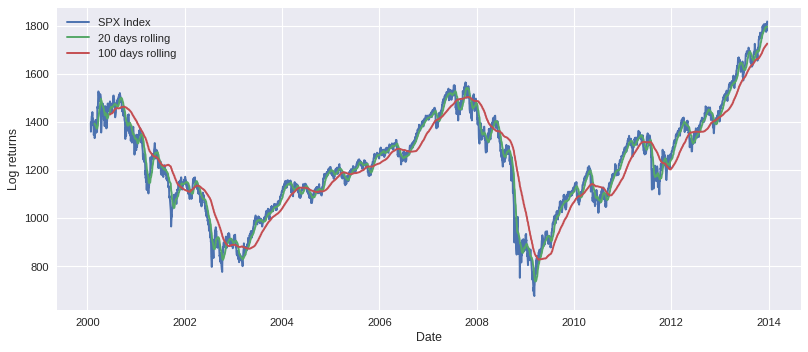

In [44]:
# Get the SPX time series. This now returns a Pandas Series object indexed by date.# Get t 
spx_index = asset_prices.loc[:, 'SPX']

short_rolling_spx = pd.core.series.Series(np.zeros(len(asset_prices.index)), index=asset_prices.index)
long_rolling_spx = short_rolling_spx

# Calculate the 20 and 100 days moving averages of log-returns
### START CODE HERE ### (≈ 2 lines of code)
### ...
short_rolling_spx = spx_index.rolling(20).mean()
long_rolling_spx = spx_index.rolling(100).mean()
### END CODE HERE ###

# Plot the index and rolling averages
fig=plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
ax.plot(spx_index.index, spx_index, label='SPX Index')
ax.plot(short_rolling_spx.index, short_rolling_spx, label='20 days rolling')
ax.plot(long_rolling_spx.index, long_rolling_spx, label='100 days rolling')
ax.set_xlabel('Date')
ax.set_ylabel('Log returns')
ax.legend(loc=2)
plt.show()

In [45]:
### GRADED PART (DO NOT EDIT) ###
np.random.seed(42)
idx_test = np.random.randint(low=100, high=len(short_rolling_spx), size=50)
result = short_rolling_spx.values[idx_test] + long_rolling_spx.values[idx_test] 


### grading results ###
part_1 = list(result.squeeze())
try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)
submissions[all_parts[0]]=part1
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:1],all_parts,submissions)
result.squeeze()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ 2939.2689,  2065.8155,  2428.6888,  2323.5646,  2228.6512,
        2832.7891,  2771.952 ,  1765.647 ,  2230.2738,  2360.8532,
        2222.0255,  2596.199 ,  1932.6528,  2930.1697,  2539.8038,
        2747.3836,  2834.7257,  3501.9293,  1912.125 ,  2172.2049,
        2534.7048,  2427.7477,  2187.8932,  2356.6817,  2238.3179,
        1994.9164,  2388.5834,  2254.9847,  3515.196 ,  2921.5941,
        1903.9954,  1854.4656,  2468.9543,  2207.0963,  2234.2487,
        2206.5196,  2610.0842,  2654.0074,  2248.4479,  2950.6151,
        2534.5414,  2675.5777,  2643.7591,  2675.5777,  1868.7086,
        2928.2838,  2391.709 ,  2439.4625,  2536.4369,  3004.7813])

### Apply scikit-learn StandardScaler to stocks log-returns

In [46]:
from sklearn.preprocessing import StandardScaler

# Standardize features by removing the mean and scaling to unit variance
# Centering and scaling happen independently on each feature by computing the relevant statistics 
# on the samples in the training set. Mean and standard deviation are then stored to be used on later 
# data using the transform method.
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

log_ret_mat_std = StandardScaler().fit_transform(asset_returns.values)
log_ret_df_std = pd.DataFrame(data=log_ret_mat_std, 
                              index=asset_returns.index,
                              columns=asset_returns.columns.values) 
log_ret_df_std.iloc[:, :10].head()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK
2000-01-28,-0.177095,-0.503576,-2.684641,-0.040166,2.149514,-2.773218,-0.199237,-0.761249,-1.539968,-1.829376
2000-01-31,-0.904935,0.110571,0.665376,-1.782203,1.346264,-1.449596,-0.716880,-0.268812,-1.898412,-0.377810
2000-02-01,2.277787,1.256534,-1.179699,1.529962,0.592079,0.461992,1.590897,0.974079,0.941618,1.258580
2000-02-02,2.421231,1.215159,-0.513727,0.472721,0.345593,2.993509,-0.610369,-1.011401,-3.407901,0.190245
2000-02-03,0.526866,-1.126343,1.464752,-0.381145,0.343102,3.840506,3.186137,-0.018661,3.936335,1.206468


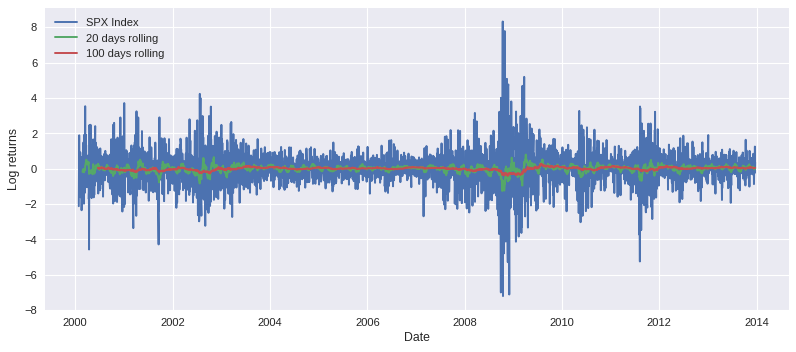

In [47]:
# Calculate the 20 and 100 days moving averages of the log-returns
short_rolling_spx = log_ret_df_std[['SPX']].rolling(window=20).mean()
long_rolling_spx = log_ret_df_std[['SPX']].rolling(window=100).mean()

# Plot the index and rolling averages
fig=plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.plot(log_ret_df_std.index, log_ret_df_std[['SPX']], label='SPX Index')
ax.plot(short_rolling_spx.index, short_rolling_spx, label='20 days rolling')
ax.plot(long_rolling_spx.index, long_rolling_spx, label='100 days rolling')
ax.set_xlabel('Date')
ax.set_ylabel('Log returns')
ax.legend(loc=2)
plt.show()

In [48]:
# Assign a label 'regime' to each date:
# 'regime' = 'benign' for all points except two intervals
# 'regime' = 'crisis_2001_2002', or
# 'regime = ', 'crisis_2007-2009'

# first assign the default value for all rows
log_ret_df_std['regime'] = 'benign'
dt_start = np.datetime64('2000-03-24T00:00:00.000000000')
dt_end = np.datetime64('2002-10-09T00:00:00.000000000')
flag_crisis_2001_2002 = np.logical_and(log_ret_df_std.index > dt_start, log_ret_df_std.index < dt_end)

dt_start = np.datetime64('2007-10-09T00:00:00.000000000')
dt_end = np.datetime64('2009-03-09T00:00:00.000000000')
flag_crisis_2007_2009 = np.logical_and(log_ret_df_std.index > dt_start, log_ret_df_std.index < dt_end)

log_ret_df_std.loc[flag_crisis_2001_2002,'regime'] = 'crisis_2001_2002'
log_ret_df_std.loc[flag_crisis_2007_2009, 'regime'] = 'crisis_2007_2009'

print('crisis_2001_2002', log_ret_df_std[log_ret_df_std.regime == 'crisis_2001_2002'].shape[0])
print('crisis_2007_2009', log_ret_df_std[log_ret_df_std.regime == 'crisis_2007_2009'].shape[0])
print(log_ret_df_std.shape)

print('Last N days of the dataset:')
log_ret_df_std.iloc[:, :10].tail()

crisis_2001_2002 635
crisis_2007_2009 354
(3492, 420)
Last N days of the dataset:


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK
2013-12-16,0.048156,0.240452,0.156457,-0.040166,0.209504,-1.308457,0.229593,0.353842,0.378619,-0.431163
2013-12-17,0.657942,0.501195,-0.180108,-0.115249,0.121412,-0.474871,0.138236,0.922656,-0.217628,0.216760
2013-12-18,0.864258,0.494531,-0.284769,0.897945,2.566273,0.747634,0.575724,1.831260,1.417926,0.549664
2013-12-19,-0.285876,0.524670,-0.415206,-0.025413,-0.169652,-0.515127,-0.082096,0.686380,0.246457,-0.183206
2013-12-20,-0.237193,-0.095901,0.250960,0.099780,-0.338791,0.610861,0.237364,-0.483890,0.404861,0.813525


In [49]:
# use data before 2012-03-26 for training, and data after it for testing

train_end = datetime.datetime(2012, 3, 26) 
df_train = log_ret_df_std[log_ret_df_std.index <= train_end].copy()
df_test = log_ret_df_std[log_ret_df_std.index > train_end].copy()
print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)

Train dataset: (3055, 420)
Test dataset: (437, 420)


### Part 2 (Returns regression on SPX Index)
**Instructions:**

- Compute $R^2$, $\alpha$, and $\beta$ for in-sample and out-of-sample regressing each stock returns on SPX returns. Use df_train and df_test data. 
- Store  in-sample $R^2$ in **R2_in_sample** list
- Store  out-of-sample $R^2$ in **R2_out_sample** list


In [50]:
# regress each individual stock on the market

from sklearn.linear_model import LinearRegression

# create a Linear Regression object
lm = LinearRegression()
stock_tickers = asset_returns.columns.values[:-1] # exclude SPX

# compute betas for all stocks in the dataset
R2_in_sample = [0.] * len(stock_tickers)
R2_out_sample = [0.] * len(stock_tickers)
betas = [0.] * len(stock_tickers)
alphas = [0.] * len(stock_tickers)

### START CODE HERE ### (≈ 10-12 lines of code)
### ...
for i in range(len(stock_tickers)):
    lm.fit(df_train['SPX'].reshape(-1,1),df_train.iloc[:,i])
    betas[i] = lm.coef_[0]
    alphas[i] = lm.intercept_
    R2_in_sample[i] = lm.score(df_train['SPX'].reshape(-1,1),df_train.iloc[:,i])
    R2_out_sample[i] = lm.score(df_test['SPX'].reshape(-1,1),df_test.iloc[:,i])
### END CODE HERE ###

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [51]:
df_lr = pd.DataFrame({'R2 in-sample': R2_in_sample, 'R2 out-sample': R2_out_sample, 'Alpha': alphas, 'Beta': betas}, 
                     index=stock_tickers)
df_lr.head(10)

,Alpha,Beta,R2 in-sample,R2 out-sample
A,0.000448,0.575501,0.328228,0.424779
AA,0.002176,0.690469,0.476366,0.388624
AAPL,0.007923,0.502159,0.253775,0.143598
ABC,-0.001616,0.402682,0.160497,0.235728
ABT,-0.000489,0.427570,0.186837,0.253681
ADBE,-0.000820,0.589522,0.343281,0.316982
ADI,0.000891,0.591461,0.342065,0.573918
ADM,0.000758,0.511483,0.263903,0.313796
ADP,-0.002394,0.621857,0.384923,0.562737
ADSK,0.003927,0.565112,0.328240,0.277875


In [52]:
### GRADED PART (DO NOT EDIT) ###

np.random.seed(42)
idx = np.random.randint(low=0, high=df_lr.shape[0], size=50)
### grading results ###
part_2 = list(df_lr.as_matrix()[idx, :].flatten())
try:
    part2 = " ".join(map(repr, part_2))
except TypeError:
    part2 = repr(part_2)

submissions[all_parts[1]]=part2
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:2],all_parts,submissions)

df_lr.as_matrix()[idx, :].flatten()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ -9.67049922e-04,   7.40733288e-01,   5.55857450e-01,
         5.09490225e-01,   4.59373236e-03,   6.46428603e-01,
         4.12381016e-01,   4.13343769e-01,  -1.67079795e-04,
         4.60162705e-01,   2.11584248e-01,   3.03661286e-01,
         3.32009347e-03,   3.29359405e-01,   1.08648285e-01,
         1.63064268e-01,  -1.95361484e-03,   4.41668666e-01,
         1.96621050e-01,   3.51790739e-01,   3.38885382e-03,
         6.61776832e-01,   4.37066392e-01,   5.46250050e-01,
        -7.10945228e-04,   6.21759216e-01,   3.82730461e-01,
         4.26154221e-01,  -9.67049922e-04,   7.40733288e-01,
         5.55857450e-01,   5.09490225e-01,   4.19833772e-03,
         4.55076530e-01,   2.07650024e-01,   1.80616581e-01,
         5.39919913e-03,   6.75964478e-01,   4.63362524e-01,
         4.76733296e-01,  -1.02424453e-03,   6.57285848e-01,
         4.26053714e-01,   4.07380380e-01,  -1.54726545e-03,
         6.51225662e-01,   4.17266938e-01,   4.40535223e-01,
        -1.62644359e-04,

#### Part 3 (Calculation of unexpected log-returns)
**Instructions:**
- Use **df_train**  and calculated in Part 2 **df_lr** with $\beta$ and $\alpha$ to compute unexpected log returns
- Calculate unexplained log-returns as difference between the stock return and its value, "predicted" by the index return.

$$ \epsilon^i_t = R^i_t - \alpha_i - \beta_i R^M_t$$
- Store unexplained log-returns in df_unexplained pnadas.DataFrame

In [53]:
df_unexplained = df_train.loc[:, stock_tickers]

### START CODE HERE ### (≈ 4-10 lines of code)
### ...
for i in stock_tickers:
    df_unexplained[i]=df_train[i]-df_lr.loc[i,'Alpha']-df_lr.loc[i,'Beta']*df_train['SPX']
### END CODE HERE ###

print('Unexplained log-returns of S&P 500 Index stocks', df_unexplained.shape)
print('Unexplained log-returns of S&P 500 Index stocks:')
df_unexplained.iloc[:, :10].head()

Unexplained log-returns of S&P 500 Index stocks (3055, 418)
Unexplained log-returns of S&P 500 Index stocks:


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK
2000-01-28,1.042699,0.958259,-1.627829,0.815262,3.056585,-1.522426,1.053955,0.322498,-0.219042,-0.635088
2000-01-31,-1.990722,-1.193765,-0.289570,-2.540007,0.540397,-2.560558,-1.833211,-1.234180,-3.068782,-1.447484
2000-02-01,1.818522,0.703883,-1.587967,1.210541,0.251689,-0.007182,1.118464,0.565542,0.448237,0.804120
2000-02-02,2.429032,1.222879,-0.514452,0.480108,0.352210,3.002779,-0.602783,-1.004828,-3.396594,0.194417
2000-02-03,0.040778,-1.711177,1.033078,-0.719335,-0.017217,3.343853,2.686136,-0.451039,3.413969,0.725667


In [54]:
### GRADED PART (DO NOT EDIT) ###
np.random.seed(42)
idx_row = np.random.randint(low=0, high=df_lr.shape[0], size=100)
np.random.seed(42)
idx_col = np.random.randint(low=0, high=df_lr.shape[1], size=100)

# grading
part_3=list(df_unexplained.as_matrix()[idx_row, idx_col])
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)

submissions[all_parts[2]]=part3
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:3],all_parts,submissions)
df_unexplained.as_matrix()[idx_row, idx_col]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ -1.06384099e+00,   2.46332604e+00,  -3.98137854e-01,
        -1.73038638e+00,  -1.24664956e+00,  -3.21817166e+00,
        -2.68605112e+00,   5.85249927e-02,  -6.03871994e-01,
         1.03144668e+00,  -6.01130305e-01,   4.94079044e-01,
         1.30232663e-01,   1.79332853e+00,  -1.80093157e-02,
         3.77015908e-01,   1.13280607e+00,   9.63269929e-01,
        -1.59153487e-01,  -8.88290688e-01,   9.21991730e-02,
        -2.31988629e+00,   5.36111856e-01,   7.33048310e-04,
         2.15086376e+00,   7.49150157e-01,  -6.54042167e-01,
         1.16224382e+00,  -2.30230439e-01,   1.44999689e+00,
         1.05277023e+00,  -7.98942377e-01,   2.02227271e+00,
         9.92660502e-01,   1.83791224e-01,  -2.03348972e+00,
         1.19212702e-02,   1.04849661e+00,  -1.63479730e+00,
        -1.49765433e+00,   7.08336754e-01,   1.68044925e+00,
         1.62131811e+00,   4.70785893e-01,   1.13280607e+00,
         2.48876285e-01,  -9.46299873e-01,   4.10043306e-01,
         7.48012073e-02,

#### Part 4 (Kernel PCA of Covariance Matrix of Returns)

**Instructions:**
- Perform Kernel PCA with 1 component using returns data **df_test** for all stocks in df_test
- Transform original mapping in the coordinates of the first principal component
- Assign tranformed returns to PCA_1 in **** DataFrame
 

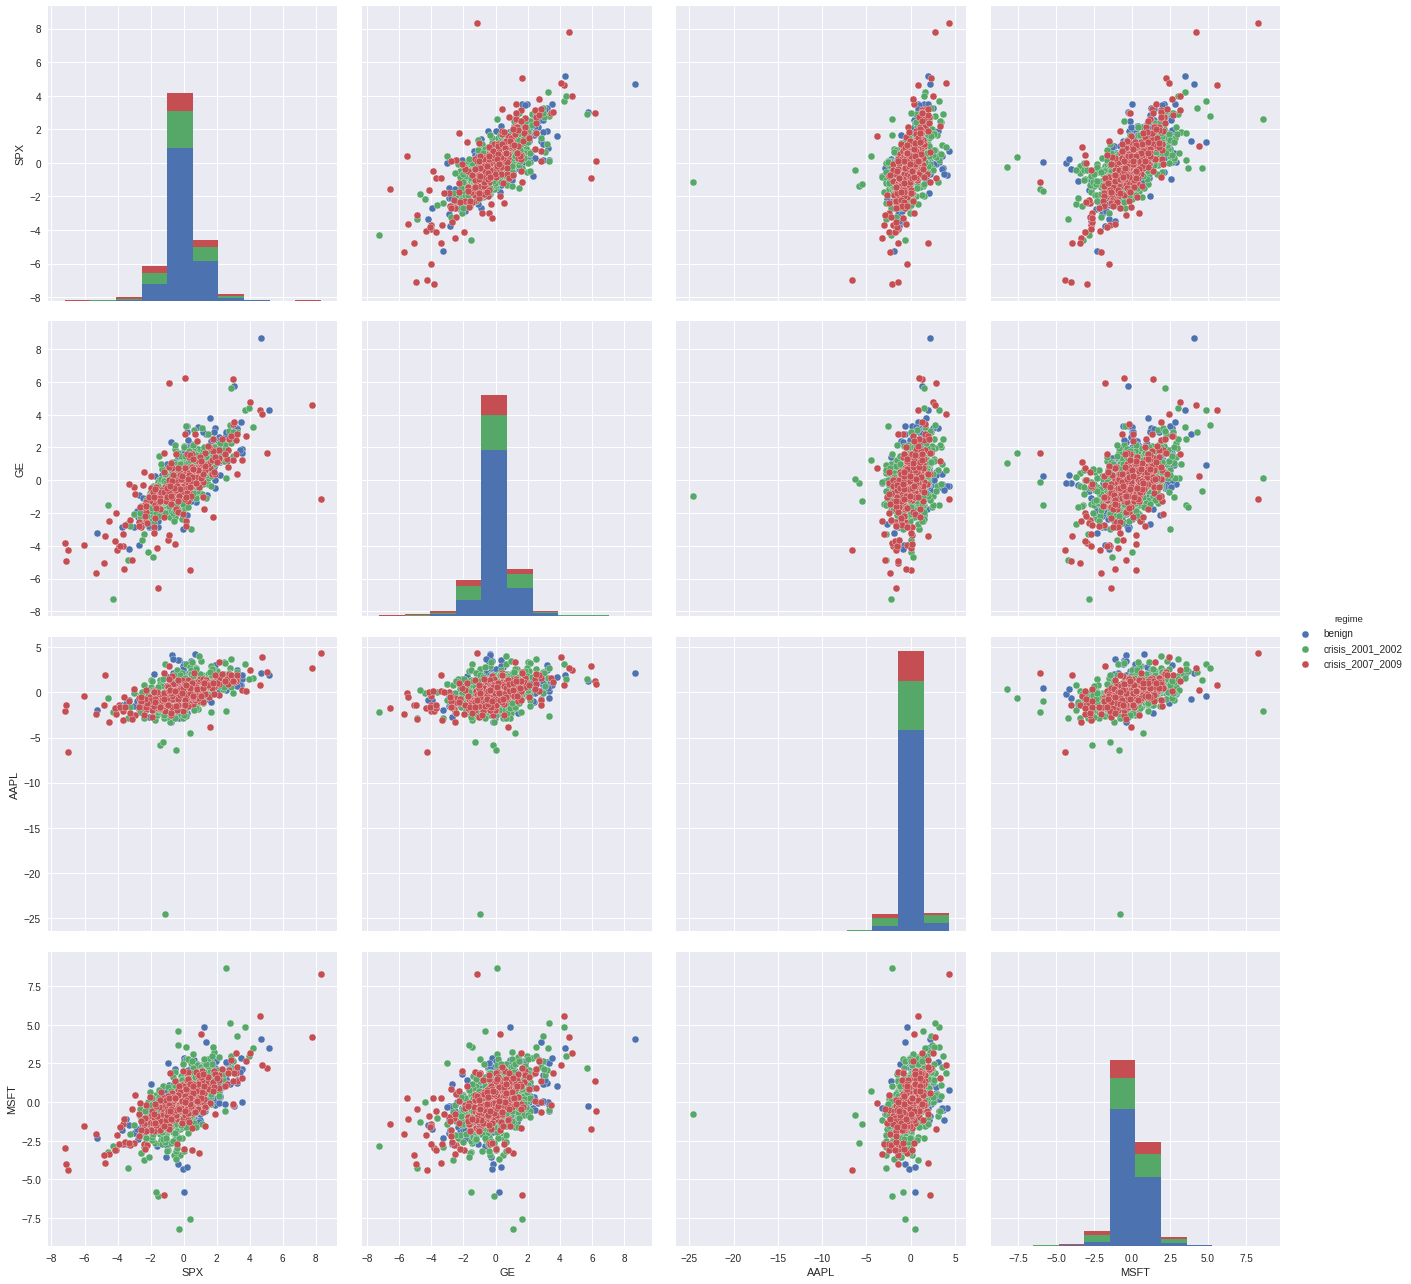

In [55]:
import seaborn as sns
sns.pairplot(df_train.loc[:, ['SPX', 'GE', 'AAPL', 'MSFT', 'regime']], 
             vars=['SPX', 'GE', 'AAPL', 'MSFT'], hue="regime", size=4.5)

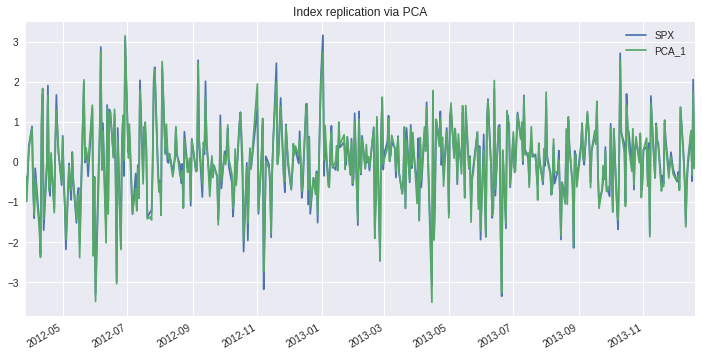

In [56]:
stock_tickers = asset_returns.columns.values[:-1]
assert 'SPX' not in stock_tickers, "By accident included SPX index"
data = df_test[stock_tickers].values

df_index_test = pd.DataFrame(data=df_test['SPX'].values, index=df_test.index, columns=['SPX'])
df_index_test['PCA_1'] = np.ones(len(df_test.index)) 

### START CODE HERE ### (≈ 2-3 lines of code)
# please set random_state=42 when initializing Kernel PCA
pca = KernelPCA(n_components=1,random_state=42)
df_index_test['PCA_1'] = pca.fit_transform(data)
### GRADED PART (DO NOT EDIT) ###

# draw the two plots
df_plot = df_index_test[['SPX', 'PCA_1']].apply(lambda x: (x - x.mean()) / x.std())
df_plot.plot(figsize=(12, 6), title='Index replication via PCA')

In [57]:
### GRADED PART (DO NOT EDIT) ###
np.random.seed(42)
transformed_first_pc = df_index_test['PCA_1'].values
idx_test = np.random.randint(low=0, high=len(transformed_first_pc), size=100)

#grading
part_4=list(np.absolute(transformed_first_pc[idx_test]))
try:
    part4 = " ".join(map(repr, part_4))
except TypeError:
    part4 = repr(part_4)

submissions[all_parts[3]]=part4
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:4],all_parts,submissions)

np.absolute(transformed_first_pc[idx_test]) # because PCA results match down to a sign
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([  2.81264873,   1.0212579 ,   3.82280109,   4.45800988,
         1.89638074,   4.93135654,   2.11776577,   9.60493421,
         2.81264873,   3.28584703,   7.92116124,   1.6025791 ,
         5.53281157,   8.55828773,   6.56407882,   2.52749704,
         8.96373405,   1.35828487,   1.22531481,  24.23713855,
         2.00760752,   1.93619077,   5.35570067,   2.60219962,
         0.34785633,  20.37301703,   0.72409454,   1.31006507,
         7.22057714,   6.16790594,   0.57324629,   1.66213893,
         1.76561837,   6.75294026,   9.73804903,   2.83802785,
         5.97808944,   4.45800988,   9.75209914,   1.30664976,
         1.47305523,   9.36604765,   9.58799909,   3.33895779,
         4.19472424,   1.35828487,   6.19673548,   0.59907927,
         9.60493421,   1.68347838,   3.05861624,  10.30909458,
         5.70803648,   3.88782753,   5.5758476 ,   0.1458809 ,
         2.01257801,   4.51134676,   0.41091121,  14.92772154,
         0.34785633,   2.19444128,   1.43233492,   4.72

### Part 5 (Visualization with t-SNE)

Lets turn attention to a popular dimensonality reduction algorithm: t-distributed stochastic neighbor embedding (t-SNE). Developed by Laurens van der Maaten and Geoffrey Hinton (see the original paper here), this algorithm has been successfully applied to many real-world datasets. 

The t-SNE algorithm provides an effective method to visualize a complex dataset. It successfully uncovers hidden structures in the data, exposing natural clusters and smooth nonlinear variations along the dimensions. It has been implemented in many languages, including Python, and it can be easily used thanks to the scikit-learn library.

**Instructions:**
- Fit TSNE with 2 components, 300 iterations. Set perplexity to 50.
- Use **log_ret_df_std** dataset for stock tickers only
- Store the results of fitting in **tsne_results** np.array

In [58]:
import time
from sklearn.manifold import TSNE

np.random.seed(42)
tsne_results = np.zeros((log_ret_df_std[stock_tickers].shape[0], 2))
perplexity = 50 
n_iter = 300
time_start = time.time()
### START CODE HERE ### (≈ 2-3 lines of code)
#... please set random_state=42 when initializing TSNE
tsne = TSNE(n_components=2,n_iter=300,perplexity=50,random_state=42)
tsne.fit(log_ret_df_std[stock_tickers])
tsne_results = tsne.fit_transform(log_ret_df_std[stock_tickers])
### GRADED PART (DO NOT EDIT) ###

In [59]:
df_tsne = pd.DataFrame({'regime': log_ret_df_std.regime.values,
                        'x-tsne': tsne_results[:,0],
                        'y-tsne': tsne_results[:,1]},
                       index=log_ret_df_std.index)
print('t-SNE (perplexity=%.0f) data:' % perplexity)
df_tsne.head(10)

t-SNE (perplexity=50) data:


,regime,x-tsne,y-tsne
2000-01-28,benign,-3.038673,-5.316556
2000-01-31,benign,-8.765260,3.094646
2000-02-01,benign,-8.244621,0.480547
2000-02-02,benign,-8.708703,-2.338986
2000-02-03,benign,-6.688275,3.085631
2000-02-04,benign,-7.527815,-4.522123
2000-02-07,benign,-7.912331,-5.846404
2000-02-08,benign,-5.841453,0.052098
2000-02-09,benign,-3.304428,-5.064686
2000-02-10,benign,-5.084796,-1.647474


In [60]:
### GRADED PART (DO NOT EDIT) ###
np.random.seed(42)
idx_row = np.random.randint(low=0, high=tsne_results.shape[0], size=100)
np.random.seed(42)
idx_col = np.random.randint(low=0, high=tsne_results.shape[1], size=100)

#grading
part_5 = list(tsne_results[idx_row, idx_col]) # because PCA results match down to a sign
try:
    part5 = " ".join(map(repr, part_5))
except TypeError:
    part5 = repr(part_5)
    
submissions[all_parts[4]]=part5
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:5],all_parts,submissions)

tsne_results[idx_row, idx_col]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ -7.27752779,   3.97922194,  -4.95499954, -11.95070426,
       -10.96153847,  -5.59631304,  -7.34812751,  -6.42637253,
        -4.34998945,  -6.89970789,  -6.51875683,  -9.59451548,
        -4.32173727,  -5.61804782,   0.25647417,  -7.91333904,
         1.84540425,  -1.59525999,  -4.69650804,  -7.82388042,
        -3.52797559, -10.35609149,  -4.82478387,  -5.21829759,
         4.16881871,   2.75929713,  -6.22412129,   0.71199362,
        -2.38738997,   3.57643448, -10.74498128,  -5.84538947,
        -4.9310639 ,   3.43898344,  -4.14266855,  -6.72443296,
        -0.89687314,  -6.06944889,  -5.1753488 ,  -8.67070395,
       -10.75367228,  -9.50263653,  -0.18979738,  -3.98885135,
        -4.31156161,  -3.98885135,   3.62077396,  -9.31454961,
        -0.86092471,   0.58070048,  -7.06093787,  -4.02564937,
        -3.09743313,   2.89553328,  -7.22889814,  -4.37827015,
        -6.69086267,  -8.95234196,  -8.61584711, -10.58632673,
        -7.53349756,  -6.40884109,  -6.62375233,  -6.60

In [61]:
def plot_tsne_2D(df_tsne, label_column, plot_title):
    """
    plot_tsne_2D - plots t-SNE as two-dimensional graph
    Arguments:
    label_column - column name where labels data is stored
    df_tsne - pandas.DataFrame with columns x-tsne, y-tsne
    plot_title - string
    """
    unique_labels = df_tsne[label_column].unique()
    print('Data labels:', unique_labels)
    print(df_tsne.shape)

    colors = [ 'b', 'g','r']
    markers = ['s', 'x', 'o']
    y_train = df_tsne.regime.values

    plt.figure(figsize=(8, 8))
    ix = 0
    bars = [None] * len(unique_labels)
    for label, c, m in zip(unique_labels, colors, markers):
        plt.scatter(df_tsne.loc[df_tsne[label_column]==label, 'x-tsne'], 
                    df_tsne.loc[df_tsne[label_column]==label, 'y-tsne'], 
                    c=c, label=label, marker=m, s=15)
        bars[ix] = plt.bar([0, 1, 2], [0.2, 0.3, 0.1], width=0.4, align="center", color=c)
        ix += 1

    plt.legend(bars, unique_labels)
    plt.xlabel('first dimension')
    plt.ylabel('second dimension')
    plt.title(plot_title)
    plt.grid()
    plt.show()

Data labels: ['benign' 'crisis_2001_2002' 'crisis_2007_2009']
(3492, 3)


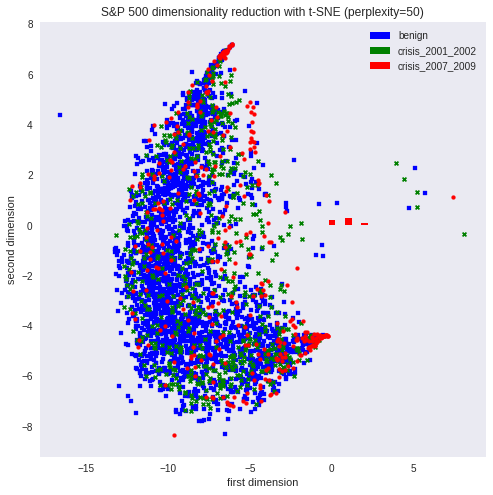

In [62]:
plot_tsne_2D(df_tsne, 'regime', 'S&P 500 dimensionality reduction with t-SNE (perplexity=%d)' % perplexity)